# Applying variograms to gridded DEMs

**Tom Chudley | Durham University | thomas.r.chudley@durham.ac.uk**

April 2023

Here, we construct variograms from ArcticDEM strip data of Sermeq Kujalleq (Store Glacier) in West Greenland, in order to explore the length scales of crevasses. 

In [1]:
import crevdem

A number of additional packages are required to run this notebook. If you are not interested in installing them manually using `conda` or similar, you can install `crevdem` from the root directory with the `variogram` tag, e.g. `pip install .[variogram]`.

In [2]:
import json

import rioxarray as rxr
import geopandas as gpd
import skgstat as skg
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.interpolate import Rbf
from sklearn.preprocessing import QuantileTransformer
from skgstat import models



In [3]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['font.sans-serif'] = "Helvetica"


## Loading the DEM and AOIs

We download a clipped cloud-optimised geotiff of the front of Sermeq Kujalleq (Store Glacier) from the ArcticDEM AWS bucket using `crevdem`.

In [4]:

geocell = 'n70w051'
dem_id = 'SETSM_s2s041_WV02_20210615_10300100BF211400_10300100C06DF000_2m_lsf_seg1'

aoi = -211000, -2.138e6, -198000, -2.126e6


In [5]:
dem = crevdem.load_aws(dataset='arcticdem', geocell=geocell, dem_id=dem_id, bounds=aoi)

Variogram analysis is highly computationally intensive. Therefore, rather than sampling the entire glacier, we will subsample smaller 1.5 km<sup>2</sup> regions. To differentiate them, we will assign them an arbritary and qualitative measure of the amount of crevassing, which we label `intensity`.

In [8]:
regions_geojson_string = '{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"intensity": 2}, "geometry": {"type": "Polygon", "coordinates": [[[-198327.05677448877, -2132380.479004478], [-199827.05677448877, -2132380.479004478], [-199827.05677448877, -2130880.479004478], [-198327.05677448877, -2130880.479004478], [-198327.05677448877, -2132380.479004478], [-198327.05677448877, -2132389.021112459], [-198327.05677448877, -2132380.479004478]]]}}, {"id": "1", "type": "Feature", "properties": {"intensity": 3}, "geometry": {"type": "Polygon", "coordinates": [[[-203467.40139216662, -2130925.2526287767], [-204967.40139216662, -2130925.2526287767], [-204967.40139216662, -2129425.2526287767], [-203467.40139216662, -2129425.2526287767], [-203467.40139216662, -2130925.2526287767], [-203467.40139216662, -2130933.7947367574], [-203467.40139216662, -2130925.2526287767]]]}}, {"id": "2", "type": "Feature", "properties": {"intensity": 0}, "geometry": {"type": "Polygon", "coordinates": [[[-200872.6597127783, -2137523.3506744555], [-202372.6597127783, -2137523.3506744555], [-202372.6597127783, -2136023.3506744555], [-200872.6597127783, -2136023.3506744555], [-200872.6597127783, -2137523.3506744555], [-200872.6597127783, -2137531.892782436], [-200872.6597127783, -2137523.3506744555]]]}}, {"id": "3", "type": "Feature", "properties": {"intensity": 4}, "geometry": {"type": "Polygon", "coordinates": [[[-205264.24171962458, -2133407.3256572867], [-206764.24171962458, -2133407.3256572867], [-206764.24171962458, -2131907.3256572867], [-205264.24171962458, -2131907.3256572867], [-205264.24171962458, -2133407.3256572867], [-205264.24171962458, -2133415.8677652674], [-205264.24171962458, -2133407.3256572867]]]}}, {"id": "4", "type": "Feature", "properties": {"intensity": 1}, "geometry": {"type": "Polygon", "coordinates": [[[-200177.78273851526, -2128740.717941893], [-201677.78273851526, -2128740.717941893], [-201677.78273851526, -2127240.717941893], [-200177.78273851526, -2127240.717941893], [-200177.78273851526, -2128740.717941893], [-200177.78273851526, -2128749.2600498735], [-200177.78273851526, -2128740.717941893]]]}}]}'
regions_geojson = json.loads(regions_geojson_string)
regions = gpd.GeoDataFrame.from_features(regions_geojson['features'], crs=3413)

regions

,geometry,intensity
0,"POLYGON ((-198327.057 -2132380.479, -199827.05...",2
1,"POLYGON ((-203467.401 -2130925.253, -204967.40...",3
2,"POLYGON ((-200872.660 -2137523.351, -202372.66...",0
3,"POLYGON ((-205264.242 -2133407.326, -206764.24...",4
4,"POLYGON ((-200177.783 -2128740.718, -201677.78...",1


Let's plot the sample regions over the DEM.

<Axes: >

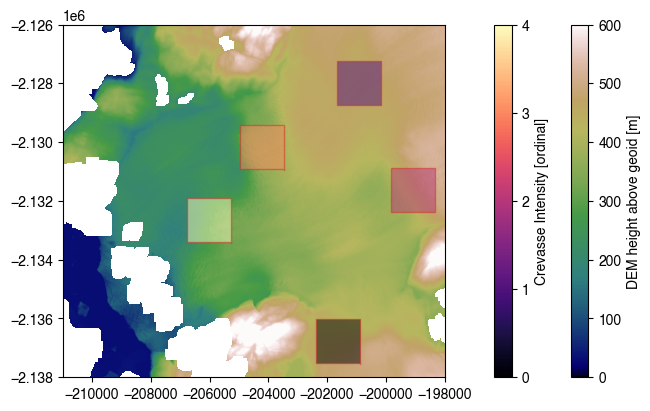

In [10]:
fig, ax = plt.subplots(figsize=(6.5,4))
extent = [dem.rio.bounds()[i] for i in [0,2,1,3]]

im=ax.imshow(dem.values, extent=extent, vmin=0, vmax=600, cmap='gist_earth')
plt.colorbar(im, ax=ax, label='DEM height above geoid [m]')

regions.plot(
    ax=ax, column='intensity', cmap='magma', 
    ec='tab:red', alpha=.5, legend=True, 
    legend_kwds={'label': 'Crevasse Intensity [ordinal]', 'ticks': [0,1,2,3,4], 'format': '%d'}
)

## Prepping the data for variograms

We set up a series of functions so that, for each sample zone, we:

 - Clip the rioxarray dataset to the sample zone AOI.
 - Convert the array into a Pandas datafram with `x`, `y`, and `z` columns.
 - Randomly subsample 2% of the full array (processing increases exponentially with the number of the points, but is very robust to subsampling).
 - Detrend the array using a radial basis function.
 - Normalise the array.

The output of these functions is a dictionary of the relevant variables for processing, most relevant being the dataframe.

Note we do not use the normalised data in the final variogram (the normalization is only necessary if the variogram is used for interpolation) but the function is left here for reference.

In [14]:

def df_from_xds(xds):

    X, Y = np.meshgrid(xds.x, xds.y)
    df = pd.DataFrame({'x': X.ravel(), 'y': Y.ravel(), 'z':xds.values.ravel()})
    return df.astype('float32')  # convert to float32 for speed


def rbf_detrend(df, xds, smooth_radius=500, resolution=2, subsample_frac=0.02, sample_frac=0.02):
    
    # calculate smoothing distance
    sigma = np.rint(smooth_radius/resolution)
    
    # subsample the sample dataframe even further (as our radius is large, RBF is 
    # robust to small sample sizes and computationally intensive)
    subsample = df.sample(frac=subsample_frac)
    
    # to make robust at margins, include corner points
    X, Y = np.meshgrid(xds.x.values, xds.y.values)
    x_corners = X[[0,0,-1,-1],[0,-1,0,-1]]
    y_corners = Y[[0,0,-1,-1],[0,-1,0,-1]]
    z_corners = xds.values[[0,0,-1,-1],[0,-1,0,-1]]
    subsample = pd.concat([subsample, pd.DataFrame({'x': x_corners, 'y': y_corners, 'z': z_corners})])
    
    # rbf
    rbfi = Rbf(
        subsample.x, subsample.y, subsample.z, 
        smooth=sigma, function='linear',
        # smooth=10, function='multiquadric',
    )
    trend = rbfi(X, Y)
    
    # calculate detrended DEM, and create new dataframe sampling the detrended DEM as well as the original DEM
    detrend = xds.values - trend
    df = pd.DataFrame({'x': X.ravel(), 'y': Y.ravel(), 'z': xds.values.ravel(), 'z_detrend':detrend.ravel()}).astype('float32').sample(frac=sample_frac)

    return detrend, df


def normal_transform(pd_series):
    
    data = pd_series.values.reshape(-1,1)
    nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
    return nst_trans.transform(data) 


def get_dem_df(xds, regions, intensity, sample_frac=0.02):
    
    bounds = regions[regions['intensity']==intensity].total_bounds
    clip_xds = xds.rio.clip_box(*bounds)
    
    df = df_from_xds(clip_xds)
    df = df.sample(frac=sample_frac)
    
    detrend, df = rbf_detrend(df, clip_xds, smooth_radius=500, resolution=2, subsample_frac=0.02)

    df['z_detrend_norm'] = normal_transform(df['z_detrend'])
    
    return {
        'intensity': intensity, 'grid': clip_xds.values, 'grid_detrend': detrend, 
        'x':clip_xds.x.values, 'y':clip_xds.y.values, 'bounds': bounds, 'df': df
    }


We loop through all of the sample regions, performing this operation on all of them:

In [15]:
samples = [get_dem_df(dem, regions, i, 0.02) for i in [0,1,2,3,4]]

## Computing the variograms

We can now create a function to compute the variogram from the detrended data. We use a `maxlag` of 200 m.

In [16]:

def compute_variogram(
    df, 
    maxlag=200,   # maximum range distance
    n_lags = 100   # number of bins
):
    """
    compute experimental (isotropic) variogram
    """
    
    coords = df[['x','y']].values
    # values = df['z']
    values = df['z_detrend']
    # values = df['z_detrend_norm']

    # compute variogram
    V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

    return V1


We loop through the sample areas, computing the variogram for each.

In [17]:
for s in samples:
    print(f'{s["intensity"]}... ', end='')
    s['variogram'] = compute_variogram(s['df'])
print('Finished.')

0... 1... 2... 3... 4... Finished.


And we can now plot the experimental and model variograms. We fit a gaussian model, which appears to match the crevassed topography best. We also visualise the `range` parameter as a vertical dashed line.

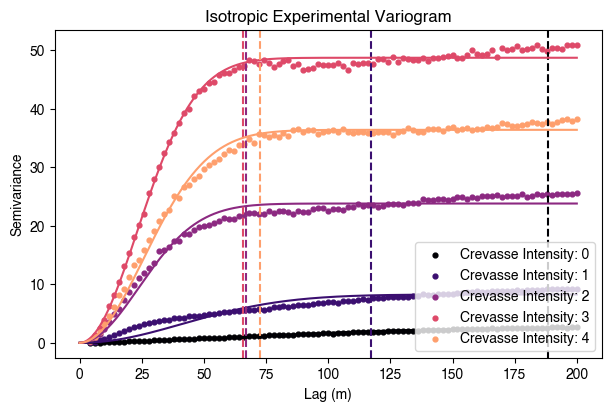

In [18]:
fig, ax = plt.subplots(figsize=(6,4))

def plot_variogram(variogram, colour, label):
    
    # plot experimental
    xdata = variogram.bins
    ydata = variogram.experimental
    ax.scatter(xdata, ydata, s=12, c=colour, label=label)

    # plot model
    variogram.model='gaussian'
    vrange, vsill, vnugget = variogram.parameters
    xi = np.linspace(0, xdata[-1], 500) 
    y_exp = [models.gaussian(h, vrange, vsill, vnugget) for h in xi]
    plt.plot(xi, y_exp,'-', color=c[0])
    plt.axvline(vrange, c=c[0], ls='--')

color = iter(plt.cm.magma(np.linspace(0, 1, 6)))

for s in samples:
    c = [next(color)]
    plot_variogram(s['variogram'], c, f'Crevasse Intensity: {s["intensity"]}')

ax.legend(loc='lower right')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()


Crevassed regions have a cluster of ranges between 60-70 m, suggested that this would be a good size for structuring element / kernels used in image processing techniques to identify crevasses in this region (e.g. high pass filters, black top hat filters, etc).

Performing this analysis on a number of Greenlandic outlet glaciers suggests that the range of crevasses zones normally varies between 50 - 70 m, leading to 60 m being determined as the default `crevdem` range with the widest generic applicability.